# Define Running Mode

'performance_validation = True' when validating the performance of the model based on last 28 training days.  
  
    
'performance_validation = False' when computing forecasts that will be submitted to Kaggle.  


In [1]:
performance_validation = False

# Import Packages

In [2]:
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
from sklearn.metrics import mean_squared_error

# Data Import and Preparation

In [3]:
if performance_validation is True:
    # Import data
    submission = pd.read_csv(
        f'{utils.get_m5_root_dir()}/data/input/sample_submission.csv')
    df_merged = pd.read_csv(
        f'{utils.get_m5_root_dir()}/data/preprocessed/tx2_hobbies_1year.csv')

    # take only values where target value is known
    df_merged = df_merged.loc[df_merged['data_type'] == 'train']

    # extract target values (last 28 days) in seperate list
    y_test = df_merged[(df_merged['date'] > '2016-03-27')]['sale']

    # replace target values in DataFrame with NaN
    df_merged['sale'].loc[df_merged['date'] > '2016-03-27'] = np.nan

else:
    # Import data
    submission = pd.read_csv(
        f'{utils.get_m5_root_dir()}/data/input/sample_submission.csv')
    df_merged = pd.read_csv(
        f'{utils.get_m5_root_dir()}/data/preprocessed/preprocessed_input_data.csv')
    
    # extract training and validation data (drop evaluation)
    df_merged = df_merged.loc[df_merged['data_type'] != 'evaluation']

c:\users\domin\anaconda3\envs\predicting-sales-data\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (14,15,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# downcast numerical values to reduce mem usage
df_merged = utils.reduce_mem_usage(df_merged)

Mem. usage of decreased to 7732.21 Mb (28.6% reduction)


In [5]:
# Convert categorical features to integers as the categorical values cause problems when using large datasets

df_merged = utils.encode_categorical(df_merged, [
    "item_id", "dept_id", "cat_id", "store_id", "state_id", "event_name_1",
    "event_type_1", "event_name_2", "event_type_2", 'd'
])

df_merged.head(10)

Mem. usage of decreased to 3894.32 Mb (28.9% reduction)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sale,date,wm_yr_wk,...,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,data_type
0,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,0,0.0,2011-01-29,11101,...,2011,13,1,3,1,0,0,0,NaN,train
1,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,0,0.0,2011-01-29,11101,...,2011,13,1,3,1,0,0,0,NaN,train
2,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,0,0.0,2011-01-29,11101,...,2011,13,1,3,1,0,0,0,NaN,train
3,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,0,0.0,2011-01-29,11101,...,2011,13,1,3,1,0,0,0,NaN,train
4,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,0,0.0,2011-01-29,11101,...,2011,13,1,3,1,0,0,0,NaN,train
5,HOBBIES_1_006_CA_1_validation,1442,3,1,0,0,0,0.0,2011-01-29,11101,...,2011,13,1,3,1,0,0,0,NaN,train
6,HOBBIES_1_007_CA_1_validation,1443,3,1,0,0,0,0.0,2011-01-29,11101,...,2011,13,1,3,1,0,0,0,NaN,train
7,HOBBIES_1_008_CA_1_validation,1444,3,1,0,0,0,12.0,2011-01-29,11101,...,2011,13,1,3,1,0,0,0,0.46,train
8,HOBBIES_1_009_CA_1_validation,1445,3,1,0,0,0,2.0,2011-01-29,11101,...,2011,13,1,3,1,0,0,0,1.56,train
9,HOBBIES_1_010_CA_1_validation,1446,3,1,0,0,0,0.0,2011-01-29,11101,...,2011,13,1,3,1,0,0,0,3.17,train


# Feature Engineering

In [6]:
# sales data

# rolling mean and rolling std (weekly, monthly, quarterly, and half-year)
df_merged['rolling_mean_t7'] = df_merged.groupby(
    ['id'])['sale'].transform(lambda x: x.shift(28).rolling(7).mean())

df_merged['rolling_std_t7'] = df_merged.groupby(
    ['id'])['sale'].transform(lambda x: x.shift(28).rolling(7).std())

df_merged['rolling_mean_t30'] = df_merged.groupby(
    ['id'])['sale'].transform(lambda x: x.shift(28).rolling(30).mean())

df_merged['rolling_std_t30'] = df_merged.groupby(
    ['id'])['sale'].transform(lambda x: x.shift(28).rolling(30).std())

df_merged['rolling_mean_t90'] = df_merged.groupby(
    ['id'])['sale'].transform(lambda x: x.shift(28).rolling(90).mean())

df_merged['rolling_std_t90'] = df_merged.groupby(
    ['id'])['sale'].transform(lambda x: x.shift(28).rolling(90).std())

# laged values
df_merged['lag_t30'] = df_merged.groupby(
    ['id'])['sale'].transform(lambda x: x.shift(30))

In [7]:
# price data
df_merged['lag_price_t1'] = df_merged.groupby(
    ['id'])['sell_price'].transform(lambda x: x.shift(1))

df_merged['rolling_price_max_t30'] = df_merged.groupby(
    ['id'])['sell_price'].transform(lambda x: x.shift(1).rolling(30).max())

df_merged['price_change_t1'] = (df_merged['lag_price_t1'] -
                                df_merged['sell_price']) / (
                                    df_merged['lag_price_t1'])

df_merged['price_change_t30'] = (df_merged['rolling_price_max_t30'] -
                                 df_merged['sell_price']) / (
                                     df_merged['rolling_price_max_t30'])

df_merged['rolling_price_std_t7'] = df_merged.groupby(
    ['id'])['sell_price'].transform(lambda x: x.rolling(7).std())

df_merged['rolling_price_std_t30'] = df_merged.groupby(
    ['id'])['sell_price'].transform(lambda x: x.rolling(30).std())

df_merged.drop(['rolling_price_max_t30', 'lag_price_t1'], inplace=True, axis=1)

In [8]:
# date data
df_merged["is_weekend"] = df_merged["wday"].isin([1, 2]).astype(np.int8)

df_merged.loc[:, 'date'] = pd.to_datetime(df_merged['date'])
df_merged['day'] = df_merged['date'].dt.day.astype(np.int8)

In [9]:
# TODO: proper feature selection (e.g. random forrest)
# for now: hardcoded list of features
features = [
    'item_id',
    'dept_id',
    'cat_id',
    'store_id',
    'state_id',
    'year',
    'month',
    'day',
    'is_weekend',
    'wday',
    'event_name_1',
    'event_type_1',
    'event_name_2',
    'event_type_2',
    'snap_CA',
    'snap_TX',
    'snap_WI',
    'sell_price',
    'lag_t30',
    'rolling_mean_t7',
    'rolling_std_t7',
    'rolling_mean_t30',
    'rolling_std_t30',
    'rolling_mean_t90',
    'rolling_std_t90',
    'price_change_t1',
    'rolling_price_std_t7',
    'rolling_price_std_t30',
]

In [10]:
# drop lines with missing values that occur due to feature engineering
df_merged = df_merged.dropna(subset=features)

# Prepare Data for Training

In [11]:
if performance_validation:
    x_train = df_merged[df_merged['date'] <= '2016-03-27'][features]
    y_train = df_merged[df_merged['date'] <= '2016-03-27']['sale']
    x_val = df_merged[(df_merged['date'] > '2016-03-27')][features]
    y_val = y_test

else:
    x_train = df_merged[df_merged['data_type'] == 'train'][features]
    y_train = df_merged[df_merged['data_type'] == 'train']['sale']
    x_val = df_merged[(df_merged['data_type'] == 'validation')][features]
    y_val = df_merged[(df_merged['data_type'] == 'validation')]['sale']
    # -> y_val always NA

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(43972762, 28)
(43972762,)
(853720, 28)
(853720,)


# Model Training & Forecasting (GradientBoostingRegressor)

In [12]:
# docu of classifier: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

clf = GradientBoostingRegressor(n_iter_no_change=5, tol=0.005, verbose=1)
clf = clf.fit(x_train, y_train)

y_pred = clf.predict(x_val)

      Iter       Train Loss   Remaining Time 
         1          16.6018          299.51m
         2          15.0881          295.26m
         3          13.8463          292.84m
         4          12.8141          289.65m
         5          11.9620          301.67m
         6          11.2558          703.54m
         7          10.6715          643.43m
         8          10.1888          602.71m
         9           9.7911          569.55m
        10           9.4633          541.81m
        20           8.0104          397.45m
        30           7.6917          322.51m
        40           7.5788          265.98m
        50           7.5124          216.51m
        60           7.4613          170.17m
        70           7.4177          126.10m
        80           7.3806           83.30m
        90           7.3566           41.38m
       100           7.3315            0.00s


# Training Analysis

In [13]:
if performance_validation:

    # R-Squared value
    print('R-Squared Value: %0.3f' % clf.score(x_val, y_val))

    # MSE of computed forecasts
    print('MSE of computed forecasts: %0.3f' %
          mean_squared_error(y_val, y_pred))

    # MSE of SARIMA
    print('MSE of SARIMA on small data set', 3.565)
    print('MSE of SARIMA on entire data set', 7.615)

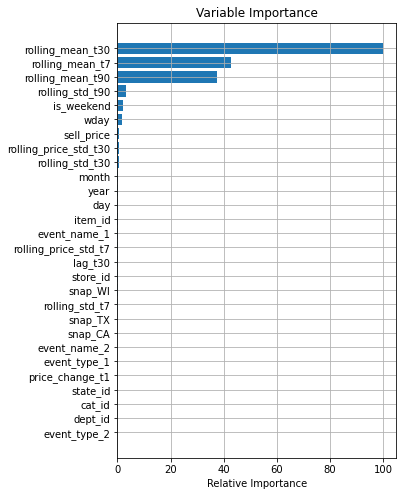

In [14]:
# Plot feature importances
feature_importance = clf.feature_importances_

feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(5, 8))
plt.grid()
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, x_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Text(0, 0.5, 'Deviance')

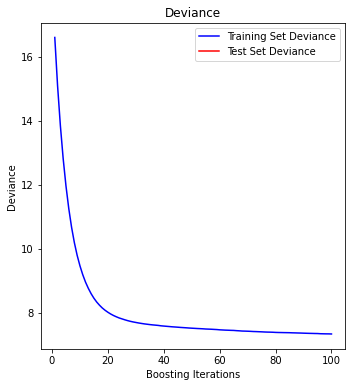

In [15]:
# Plot training deviance

test_score = np.zeros((len(clf.estimators_), ), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(x_val)):
    test_score[i] = clf.loss_(y_val, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(len(clf.estimators_)) + 1,
         clf.train_score_,
         'b-',
         label='Training Set Deviance')
plt.plot(np.arange(len(clf.estimators_)) + 1,
         test_score,
         'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# Printout Forecasts

In [16]:
# map forecast values to encoded item_ids
x_val['y_pred'] = y_pred

In [17]:
# map encoded ids to decoded ids
id_mapping_table = df_merged[['id', 'item_id', 'store_id']].drop_duplicates()
df_results = x_val.merge(id_mapping_table,
                         on=['item_id', 'store_id'],
                         how='left')[[
                             'id', 'item_id', 'store_id', 'year', 'month',
                             'day', 'y_pred'
                         ]]

In [18]:
# create dict with IDs and forecasts
submission_dict = {}

for i, df in df_results.groupby(['id']):
    df = df.reset_index(drop=True)
    submission_dict[i] = df['y_pred']

In [19]:
# convert dict to dataframe
submission_df = pd.DataFrame(submission_dict).T
submission_df.reset_index(level=0, inplace=True)
submission_df.columns = ['id'] + [f'F{di}' for di in list(range(1, 29))]
submission_df

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.791531,0.687453,0.687453,0.687453,0.812982,0.973923,1.041051,1.021580,0.977885,...,0.918795,1.177635,1.105582,1.032853,0.980919,0.980919,0.976542,1.026192,1.187134,1.187134
1,FOODS_1_001_CA_2_validation,0.802732,0.760502,0.683110,0.683110,0.732760,0.775754,0.842881,0.626167,0.665097,...,0.603785,0.835638,1.688601,1.371773,1.258716,1.212429,1.314401,1.393870,1.836921,1.419995
2,FOODS_1_001_CA_3_validation,1.418598,1.357047,1.357047,1.165723,1.188511,1.085778,1.152905,0.978981,0.940578,...,1.162759,1.305812,1.909826,1.494068,1.408784,1.277134,1.272757,1.322407,1.578423,1.185130
3,FOODS_1_001_CA_4_validation,0.420082,0.391882,0.369890,0.354540,0.404190,0.489040,0.508757,0.425243,0.400869,...,0.290810,0.409781,0.406132,0.285249,0.233315,0.233315,0.228938,0.305009,0.459581,0.511504
4,FOODS_1_001_TX_1_validation,0.767722,0.725493,0.699072,0.699072,0.459983,0.585296,0.652423,0.527680,0.419367,...,0.326190,0.445160,0.448986,0.285055,0.214971,0.214971,0.210593,0.260244,0.357194,0.357194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,0.266016,0.237816,0.259809,0.259809,0.287467,0.413028,0.396302,0.266097,0.268144,...,0.285034,0.458848,0.418189,0.241607,0.200494,0.226914,0.226914,0.276565,0.354396,0.303281
30486,HOUSEHOLD_2_516_TX_3_validation,0.170681,0.151344,0.184148,0.171568,0.221218,0.309695,0.333225,0.205082,0.180708,...,0.570215,0.525753,0.529579,0.421960,0.380847,0.380847,0.380847,0.435971,0.518991,0.518991
30487,HOUSEHOLD_2_516_WI_1_validation,0.161345,0.133145,0.133145,0.133145,0.182796,0.250282,0.273812,0.180372,0.155998,...,0.199309,0.262292,0.266118,0.174032,0.132919,0.132919,0.132919,0.182570,0.250055,0.250055
30488,HOUSEHOLD_2_516_WI_2_validation,0.152456,0.124256,0.124256,0.124256,0.173907,0.241392,0.264922,0.180372,0.155998,...,0.190420,0.262292,0.266118,0.165143,0.124030,0.124030,0.124030,0.173680,0.241166,0.241166


# Submit to Kaggle 

In [20]:
if performance_validation is False:
    # Bring data to Kaggel's required form (evaluation & validation)
    df_submission = submission_df.append(
        submission_df.replace(to_replace='validation', value='evaluation',
                              regex=True))
    filename = utils.get_m5_root_dir(
    ) + '/data/submissions/gradient_boosting_regressor_v_1_1.csv'
    df_submission.to_csv(filename, index=False)
    

    # Submit via Kaggle API or with website https://www.kaggle.com/c/m5-forecasting-accuracy/submissions
    #!kaggle competitions submit - c m5-forecasting-accuracy - f data/submissions/gradient_boosting_regressor_v_1_0.csv - m"gradient_boosting_regressor_v_1_0.csv"